In [24]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
from SpatioFreq import SpatioFreq
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/root/anaconda3/envs/SpatioFreq/lib/R'
os.environ['R_USER'] = '/root/anaconda3/envs/SpatioFreq/lib/python3.8/site-packages/rpy2'

In [ ]:
dataset = '151673'
n_clusters = 5 if dataset in ['151669', '151670', '151671', '151672'] else 7
file_fold = '/data/SpatioFreq-main/Data/DLPFC/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


73:600:3500:random seed: 6497
6382:0.671
76:seed: 5549:0.603
510:seed: 8951:0.516

In [27]:
model = SpatioFreq.SpatioFreq(adata, device=device,datatype = '10X',epochs=600,n_top_genes=3500,random_seed=6382,use_frequency_features=True)
adata = model.train()

Using random seed: 6382
Integrating frequency features...
Performing PCA to reduce dimensions...
3500
Features after PCA reduction: torch.Size([3639, 3500])
Begin to train ST data...


100%|██████████| 600/600 [00:50<00:00, 11.78it/s]


Optimization finished for ST data!


In [28]:
radius =25
tool = 'mclust' 
from SpatioFreq.utils import clustering
if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

fitting ...
  |======================================================================| 100%


In [29]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [39]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

/tmp/ipykernel_53512/1127930335.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: 151673
ARI: 0.6813537833782262


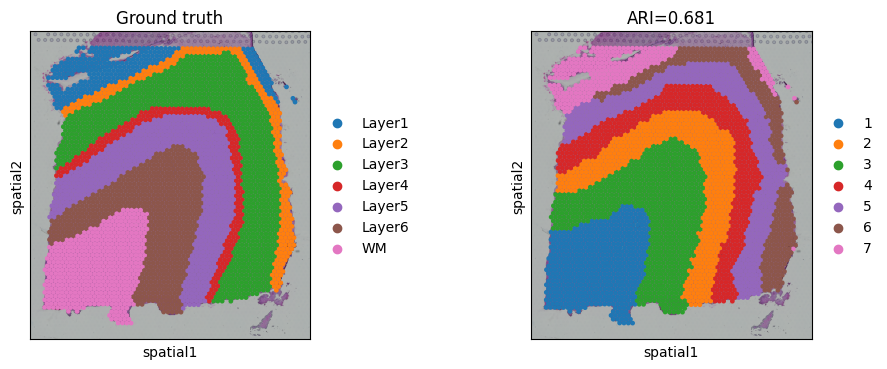

In [40]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["ground_truth", "domain"],
    title=["Ground truth", f"ARI={ARI:.3f}"],
    spot_size=150,
    show=True
)


/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

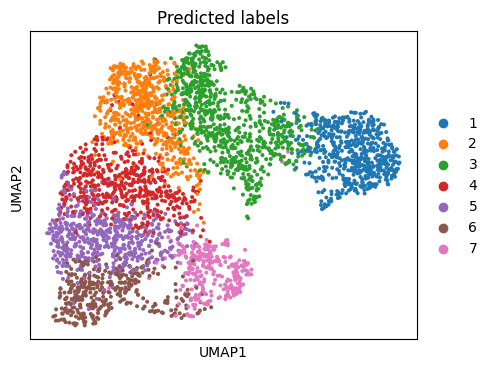

In [33]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=7)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)

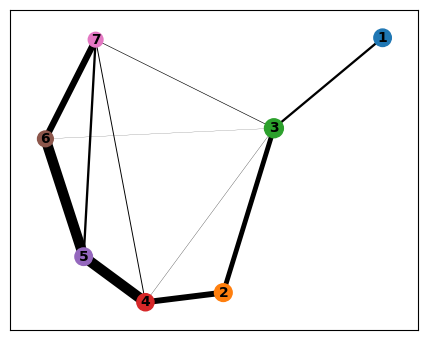

In [34]:
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.paga(adata, groups='domain')
sc.pl.paga(adata)

/root/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

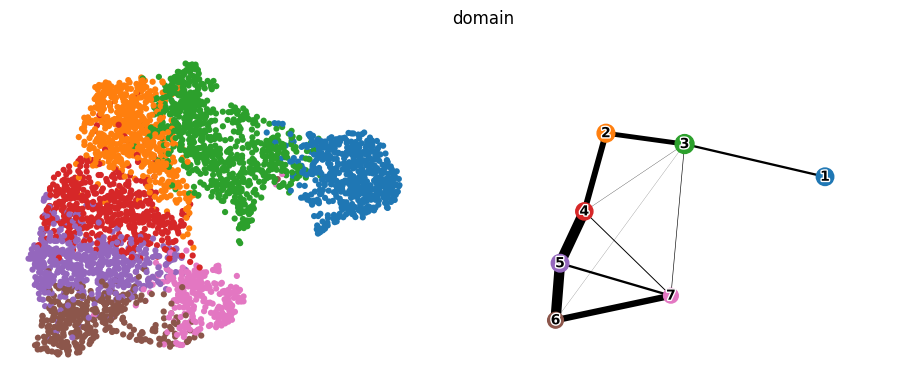

In [35]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.paga_compare(
    adata,
    legend_fontsize=10,
    frameon=False,
    size=80,
    threshold=0.01,
    legend_fontoutline=2,
    legend_loc='none',
    show=False,
)
# plt.savefig("paga_compare_transparent.png", transparent=True)


In [36]:
# import pandas as pd
# import os

# # 定义文件夹路径
# folder_path = '/data/GraphST-main/Data/DLPFC/data_without_freq/'

# # 获取路径下的所有CSV文件，并按照文件名顺序排序
# file_list = sorted(
#     [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')],
#     key=lambda x: int(os.path.basename(x).split('.')[0])  # 提取文件名中的数字部分进行排序
# )

# # 读取并整合所有CSV文件
# dataframes = [pd.read_csv(file) for file in file_list]
# combined_df = pd.concat(dataframes, ignore_index=True)

# # 保存到一个新的CSV文件中
# output_path = os.path.join(folder_path, 'combined_file.csv')
# combined_df.to_csv(output_path, index=False)

# print(f"整合后的文件已按照顺序保存到：{output_path}")
